# Predict Effects of Alzheimer's Variants Using ATAC Models

In [2]:
import anndata as ad
import pandas as pd
import numpy as np

## Load the CATlas model

This is a binary classification model trained on snATAC-seq data from Catlas (http://catlas.org/humanenhancer/)

In [3]:
import grelu.resources
model = grelu.resources.load_model(project='human-atac-catlas', model_name='tutorial_model')

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lal-avantika (grelu). Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact tutorial_model:latest, 1187.53MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.9
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.0


## View the model's metadata

`model.data_params` is a dictionary containing metadata about the data used to train the model. Let's look at what information is stored:

In [4]:
for key in model.data_params.keys():
    if key !="tasks":
        print(key, model.data_params[key])

train_n_seqs 982845
val_n_seqs 55832
train_seq_len 200
val_seq_len 200
train_rc True
val_rc False
train_max_shift 0
val_max_shift 0
train_max_offset 3
val_max_offset 0
train_n_augmented 14
val_n_augmented 1
train_chroms ['chr1', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9']
val_chroms ['chr10']


Note the parameter `train_seq_len`. This tells us that the model was trained on 200 bp long sequences.

`model.data_params['tasks']` is a large dictionary containing metadata about the output tracks that the model predicts. We can collect these into a dataframe called tasks:

In [5]:
tasks = pd.DataFrame(model.data_params['tasks'])
tasks.head(3)

,name
0,Follicular
1,Fibro General
2,Acinar


## Load Alzheimer's Variants from GWAS Catalog (Jansen et al. 2019 meta-analysis)

Download AD sumstats file from catalog, Jansen et al. 2019 meta analysis. This contains 13,367,299 variants.

In [5]:
# wget http://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST007001-GCST008000/GCST007320/AD_sumstats_Jansenetal_2019sept.txt.gz #hg19

In [6]:
snps = pd.read_table('AD_sumstats_Jansenetal_2019sept.txt.gz') 
snps.columns = ['snpid', 'chrom', 'pos', 'alt', 'ref', 'rsid', 'zscore', 'pval', 'nsum', 'neff', 'direction', 'eaf', 'beta', 'se']

snps.chrom = 'chr' + snps.chrom.astype(str)
snps.head(3)

,snpid,chrom,pos,alt,ref,rsid,zscore,pval,nsum,neff,direction,eaf,beta,se
0,1:715265_T_C,chr1,715265,T,C,rs12184267,2.121973,0.03384,359856,359856.0,??+?,0.040807,0.012643,0.005958
1,1:715367_G_A,chr1,715367,G,A,rs12184277,1.957915,0.05024,360230,360230.0,??+?,0.041069,0.011624,0.005937
2,1:717485_A_C,chr1,717485,A,C,rs12184279,1.912438,0.05582,360257,360257.0,??+?,0.040576,0.011419,0.005971


## Filter variants

We don't want to predict variant effects for all these, so let's apply a lenient pval cutoff (e.g. 1e-4) to reduce number while taking subthreshold variants into account too.

In [7]:
snps = snps[(snps.beta.abs()>0) & (snps.pval<1e-4)]
len(snps)

9989

In [8]:
from grelu.data.preprocess import filter_blacklist, filter_chromosomes
from grelu.variant import filter_variants

Remove indels, since we don't support them for now. We also remove variants where one of the alleles contains Ns.

In [9]:
snps = filter_variants(snps, max_del_len=0, max_insert_len=0, standard_bases=True)

Initial number of variants: 9989
Final number of variants: 9801


Remove non-standard chromosomes

In [10]:
snps = filter_chromosomes(snps, include='autosomesXY')

Keeping 9801 intervals


Remove SNPs from unmappable regions

In [11]:
snps = filter_blacklist(snps, genome="hg19", window=100).reset_index(drop=True)

Keeping 9786 intervals


In [12]:
snps.set_index('snpid', inplace=True)
snps.head(3)

,chrom,pos,alt,ref,rsid,zscore,pval,nsum,neff,direction,eaf,beta,se
snpid,,,,,,,,,,,,,
1:906769_A_C,chr1,906769,A,C,rs78850589,4.060775,0.000049,364859,364859.0,??+?,0.001725,0.114563,0.028212
1:985377_T_C,chr1,985377,T,C,rs113020870,3.991380,0.000066,364185,364185.0,??+?,0.002895,0.087045,0.021808
1:5175897_T_C,chr1,5175897,T,C,rs4949167,-3.920242,0.000088,17477,17477.0,???-,0.460200,-0.042052,0.010727


## Predict variant effects

The `grelu.variant` module contains several functions related to analysis of variants. The `predict_variant_effects` function takes a model and a dataframe of variants, and uses the model to predict the activity of the genomic regions containing both the ref and alt alleles. It can then compare the two predictions and return an effect size for each variant. We can also apply data augmentation, i.e. make predictions for several versions of the sequence and average them together.

In [15]:
import grelu.variant

odds = grelu.variant.predict_variant_effects(
    variants=snps,
    model=model, 
    devices=0, # Run on GPU 0
    num_workers=8,
    batch_size=512,
    genome="hg19",
    compare_func="log2FC", # Return the log2 fold change between alt and ref predictions
    return_ad=True, # Return an anndata object.
    rc = True, # Reverse complement the ref/alt predictions and average them.
)

making dataset


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:05<00:00, 15.32it/s]


Now this (odds) is an AnnData object (similar to `SingleCellExperiment` in R but in Python). Might be a good point to pause here and learn more about it: <https://anndata.readthedocs.io/en/latest/>.

In [16]:
odds

AnnData object with n_obs × n_vars = 9786 × 203
    obs: 'chrom', 'pos', 'alt', 'ref', 'rsid', 'zscore', 'pval', 'nsum', 'neff', 'direction', 'eaf', 'beta', 'se'

In [17]:
# var contains the tasks
odds.var.head(3)

""
name
Follicular
Fibro General
Acinar


In [18]:
# obs contains the 
odds.obs.head(3)

,chrom,pos,alt,ref,rsid,zscore,pval,nsum,neff,direction,eaf,beta,se
snpid,,,,,,,,,,,,,
1:906769_A_C,chr1,906769,A,C,rs78850589,4.060775,0.000049,364859,364859.0,??+?,0.001725,0.114563,0.028212
1:985377_T_C,chr1,985377,T,C,rs113020870,3.991380,0.000066,364185,364185.0,??+?,0.002895,0.087045,0.021808
1:5175897_T_C,chr1,5175897,T,C,rs4949167,-3.920242,0.000088,17477,17477.0,???-,0.460200,-0.042052,0.010727


## Select a variant with effect specific to microglia

As an example, we search for variants that strongly disrupt accessibility in microglia but not in all cell types.

We set some arbitrary thresholds; The log2 fold change of the alt allele w.r.t the ref allele should be < -3, and the average log2 fold change of the alt allele w.r.t the ref allele should be nonnegative.

This implies that the alt allele should decrease accessibility in microglia to < 1/8 of its reference
value, but should not decrease accessibility across all cell types on average.

In [20]:
# Calculate the mean variant effect across all cell types
mean_variant_effect = odds.X.mean(1) 

In [21]:
# Calculate the variant effect only in microglia
microglia_effect = odds[:, 'Microglia'].X.squeeze() 

In [22]:
microglia_specific_variants = odds[np.where(
    (microglia_effect < -3) & (mean_variant_effect >= 0) 
)[0], :]

microglia_specific_variants

View of AnnData object with n_obs × n_vars = 2 × 203
    obs: 'chrom', 'pos', 'alt', 'ref', 'rsid', 'zscore', 'pval', 'nsum', 'neff', 'direction', 'eaf', 'beta', 'se'

In [23]:
microglia_specific_variants.obs

,chrom,pos,alt,ref,rsid,zscore,pval,nsum,neff,direction,eaf,beta,se
snpid,,,,,,,,,,,,,
4:112976517_T_C,chr4,112976517,T,C,rs7692142,4.852056,0.000001,434177,427660.96,?+++,0.298691,0.011463,0.002362
6:76659840_T_G,chr6,76659840,T,G,rs138940043,4.009219,0.000061,363637,363637.00,??+?,0.006560,0.058235,0.014525


We will pick one of these microglia specific variants to analyze further.

In [24]:
variant = microglia_specific_variants.obs.iloc[[1], :]
variant

,chrom,pos,alt,ref,rsid,zscore,pval,nsum,neff,direction,eaf,beta,se
snpid,,,,,,,,,,,,,
6:76659840_T_G,chr6,76659840,T,G,rs138940043,4.009219,0.000061,363637,363637.0,??+?,0.00656,0.058235,0.014525


Let's look at the effect size (log2FC) for this variant:

In [25]:
variant_effect_size = microglia_specific_variants[1, "Microglia"].X
variant_effect_size

ArrayView([[-3.0267072]], dtype=float32)

## View importance scores in microglia for the bases surrounding the selected variant

We can use DeepSHAP to calculate attributions for each base in the reference and alternate sequence. However, we want to score each base specifically by its importance to the model's prediction in microglia and not the model's predictions on other tasks.

To do this we define a transform that operates on the model's predictions and selects only the predictions in Microglia.

In [27]:
from grelu.transforms.prediction_transforms import Aggregate
microglia_score = Aggregate(tasks=["Microglia"], model=model)

Next, we extract the 200 bp long genomic sequences containing the reference and alternate alleles.

In [28]:
ref_seq, alt_seq = grelu.variant.variant_to_seqs(
    seq_len=model.data_params['train_seq_len'],
    genome='hg19',
    **variant.iloc[0][["chrom", "pos", "ref", "alt"]]
)

ref_seq, alt_seq

('CAAAGATATATGTCATAATAATTATCTTTTCACTTTCTTTGTTAGGGACCAGGAATGATAAACCACTTAGTCATTTTTTAGGTTTACAAGAACTTAAGGGGAACTAAGAAAGGAACCCTTACTCCTGAACTCTCAGCCTCATCTGTGCTGGACCATTCTAACTTTGTACCCTTTCATGAGATTGATATAATTTAGAAAAT',
 'CAAAGATATATGTCATAATAATTATCTTTTCACTTTCTTTGTTAGGGACCAGGAATGATAAACCACTTAGTCATTTTTTAGGTTTACAAGAACTTAAGGTGAACTAAGAAAGGAACCCTTACTCCTGAACTCTCAGCCTCATCTGTGCTGGACCATTCTAACTTTGTACCCTTTCATGAGATTGATATAATTTAGAAAAT')

We are now ready to calculate the per-base attribution scores. For this, we use the `grelu.interpret.score` module, which contains functions related to scoring the importance of each base in a sequence.

In [29]:
import grelu.interpret.score

ref_attrs = grelu.interpret.score.get_attributions(
    model, ref_seq, prediction_transform=microglia_score, device=0, seed=0
)

alt_attrs = grelu.interpret.score.get_attributions(
    model, alt_seq, prediction_transform=microglia_score, device=0, seed=0
)

We can visualize the attribution scores for the center of the sequence, highlighting the bases near the variant.

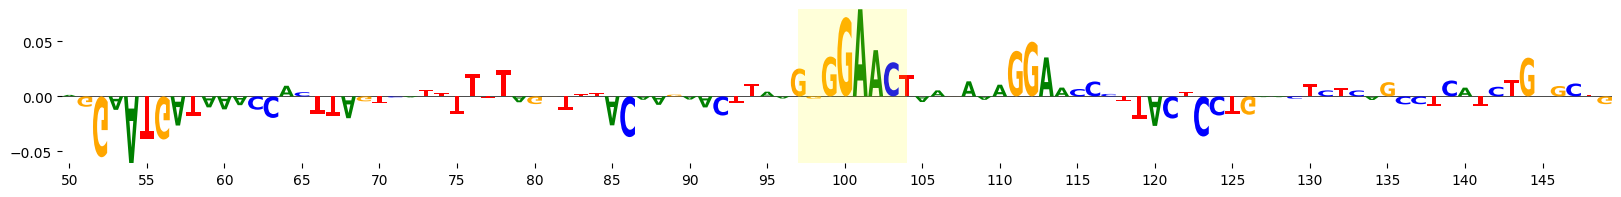

In [30]:
import grelu.visualize
grelu.visualize.plot_attributions(
    ref_attrs, start_pos=50, end_pos=150,
    highlight_centers=[100], highlight_width=7, ticks=5
)

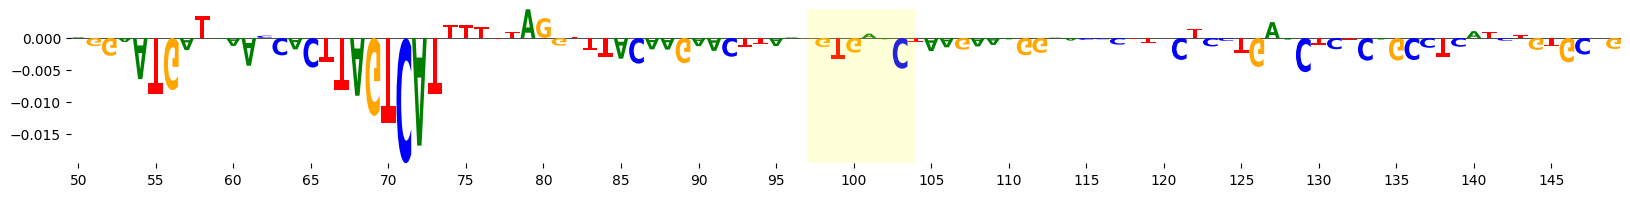

In [31]:
grelu.visualize.plot_attributions(
    alt_attrs, start_pos=50, end_pos=150,
    highlight_centers=[100], highlight_width=7, ticks=5
)

## ISM

We can also perform ISM (In silico mutagenesis) of the bases surrounding the variant to see what the effect would be if we mutated the reference allele to any other base. The `ISM_predict` function in `grelu.interpret.score` performs every possible single-base substitution on the given sequence, predicts the effect of each substitution, and optionally compares these predictions to the reference sequence to return an effect size for each substitution. 

Once again, since we are interested in how important each base is to the model's prediction in microglia,
we use the `microglia_score` transform. This ensures that ISM will score each base's importance to the
microglial prediction only.

In [32]:
ism = grelu.interpret.score.ISM_predict(
    ref_seq,
    model,
    prediction_transform=microglia_score, # Focus on the prediction in microglia
    compare_func = "log2FC", # Return the log2FC of the mutated sequence prediction w.r.t the reference sequence
    devices=0, # Index of the GPU to use
    num_workers=8,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.68it/s]


In [33]:
ism

,C,A,A,A,G,A,T,A,T,A,...,T,T,T,A,G,A,A,A,A,T
A,0.021837,0.000000,0.000000,0.000000,0.064612,0.000000,0.074665,0.000000,0.141144,0.000000,...,0.024487,0.240718,-0.071944,-0.001468,0.079579,-0.001468,-0.001468,-0.001468,-0.001468,0.031891
C,0.000000,0.054875,0.060171,-0.006697,0.100235,0.011247,-0.081919,0.229981,0.048716,0.078175,...,0.015034,-0.062364,-0.053532,0.006155,-0.068569,-0.023276,-0.060475,-0.029509,0.013227,-0.022191
G,0.008266,0.038188,0.081425,-0.067932,0.000000,-0.229953,0.079916,0.106205,0.191925,-0.116608,...,0.022168,0.002151,-0.070838,-0.094638,-0.001468,0.094412,-0.058587,-0.011603,-0.022865,0.009309
T,0.072648,0.033402,0.077830,-0.216194,0.104233,0.080246,0.000000,-0.113641,0.000000,0.175164,...,0.000000,0.000000,-0.001468,-0.178753,0.111556,0.017715,-0.178771,0.042552,0.009940,-0.001468


<Axes: >

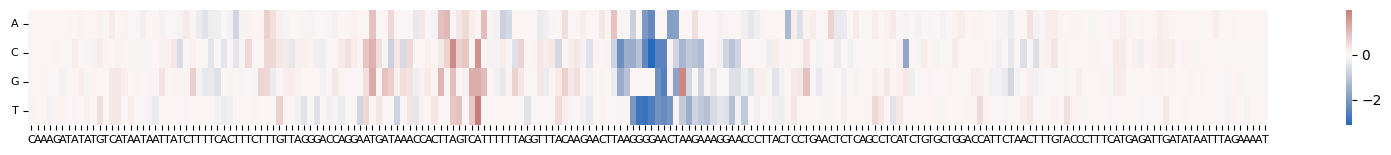

In [34]:
grelu.visualize.plot_ISM(ism, method="heatmap", center=0, figsize=(20, 1.5))

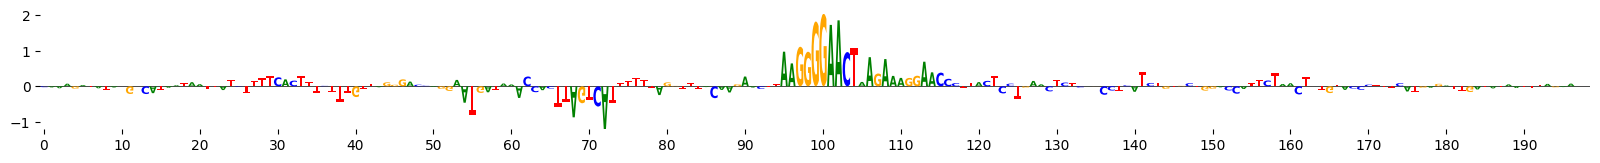

In [35]:
grelu.visualize.plot_ISM(ism, method='logo', figsize=(20, 1.5))

## Scan variant with JASPAR consensus motifs

We now scan the sequences immediately around the variant to identify known TF motifs that may have been disrupted by the variant.

In [36]:
# Select the central bases of the sequence
central_ref_seq = grelu.sequence.utils.resize(ref_seq, 20)
central_alt_seq = grelu.sequence.utils.resize(alt_seq, 20)

central_ref_seq, central_alt_seq

('AACTTAAGGGGAACTAAGAA', 'AACTTAAGGTGAACTAAGAA')

We can use the `grelu.interpret.motifs` module to scan these sequences with TF motifs. Here, we use a reference set of non-redundant motifs (https://www.vierstra.org/resources/motif_clustering) that are provided with gReLU as `consensus`.

In [37]:
# Scan with motifs
import grelu.interpret.motifs

scan = grelu.interpret.motifs.scan_sequences(
    seqs=[central_ref_seq, central_alt_seq],
    motifs='consensus',
    seq_ids=['ref', 'alt'],
    pthresh=1e-3,
    rc=True # Scan both strands
)
scan.head()

Read 637 motifs from file.


,motif,sequence,start,end,strand,score,pval
0,AC0076:OVOL:C2H2_ZF,ref,17,9,-,7.370000,0.000706
1,AC0079:ZNF:C2H2_ZF,alt,15,2,-,1.918367,0.000258
2,AC0144:IKZF_NFKB:C2H2_ZF,ref,13,9,-,9.795918,0.000782
3,AC0175:MZF:C2H2_ZF,ref,13,6,-,8.070707,0.000656
4,AC0175:MZF:C2H2_ZF,ref,12,5,-,7.515152,0.000915


In [38]:
# Compare the results for alt and ref sequences
scan = scan.pivot_table(index=['motif', 'start', 'end', 'strand'], columns=['sequence'],
                 values='score').fillna(0).reset_index()
scan['foldChange'] = scan.alt/scan.ref

scan

sequence,motif,start,end,strand,alt,ref,foldChange
0,AC0076:OVOL:C2H2_ZF,17,9,-,0.000000,7.370000,0.000000
1,AC0079:ZNF:C2H2_ZF,15,2,-,1.918367,0.000000,inf
2,AC0144:IKZF_NFKB:C2H2_ZF,13,9,-,0.000000,9.795918,0.000000
3,AC0175:MZF:C2H2_ZF,12,5,-,0.000000,7.515152,0.000000
4,AC0175:MZF:C2H2_ZF,13,6,-,0.000000,8.070707,0.000000
5,AC0176:MZF:C2H2_ZF,14,7,-,0.000000,9.000000,0.000000
6,AC0177:ZNF_MZF:C2H2_ZF,17,6,-,0.000000,8.431193,0.000000
7,AC0186:ZNF:C2H2_ZF,17,8,-,0.000000,6.064220,0.000000
8,AC0227:SPI_BCL11A:Ets,6,17,+,5.727273,11.954545,0.479087
9,AC0477:ZNF:C2H2_ZF,16,3,-,0.000000,5.397959,0.000000


Note that the `AC0622:ELF_SPIB:Ets` motif is lost in the alternate allele-containing sequence.

## Compare the variant impact to a background distribution

We saw that the variant has a strong effect size (log2 fold change). To place this effect size in context, we create a set of background sequences by shuffling the sequence surrounding the variant while conserving dinucleotide frequency. We then insert the reference and alternate alleles in each shuffled sequence, and compute the variant effect size again. 

In [42]:
test = grelu.variant.marginalize_variants(
    model=model,
    variants=variant,
    genome="hg19",
    prediction_transform=microglia_score,
    seed=0,
    n_shuffles=100,
    compare_func="log2FC",
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting variant effects
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting variant effects in background sequences
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]
Calculating background distributions
Performing 2-sided test


In [43]:
test

{'effect_size': [-2.9125452041625977],
 'mean': [-0.038239285349845886],
 'sd': [0.42197421193122864],
 'pvalue': [9.654079002785028e-12]}